# Data analysis: Digital
### October 26th 2021
<p>
Authors: <b> Stefano Barbero, Valerio Pagliarino, Matteo Barbagiovanni, Federico Malnati </b> <p>Electronics Laboratory 2021 - Department of Physics - University of Turin <p>
Date: 26/10/2021




## Configuration

### Clone the GIT

In [ ]:
!rm -r ./sample_data
import os
from getpass import getpass
user = input('GitHub user')
mail = input('GitHub email')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/valeriopagliarino/Electronics-2021-UNITO.git
!git config --global user.email user
!git config --global user.name mail

### Install environment

In [ ]:
exec(open("./Electronics-2021-UNITO/analysis/ROOT-config.py").read())

### Importa moduli [COLAB]

In [3]:
!pip3 install uncertainties
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from uncertainties import ufloat
import uncertainties.umath
from matplotlib import pyplot as plt
import pickle #Pickle with dict of Numpy arrays

# Variables for directories
DATADIR = "/content/Electronics-2021-UNITO/data-source"
OUTPUTDIR = "/content/Electronics-2021-UNITO/analysis/output"

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### Importa moduli [no COLAB]

In [4]:
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd

from matplotlib import pyplot as plt

from uncertainties import ufloat
import uncertainties.umath

import pickle

import ROOT # Per COLAB importato da ROOT-config.py

DATADIR = "../data-source"
OUTPUTDIR = "./output"

In [5]:
import csv

def cellFromCSV(path, row_index, col_index):
  with open(path, 'r') as f:
    mycsv = csv.reader(f)
    column = []
    for row in mycsv:
        column.append(row[col_index])

  return column[row_index]


def openTek(path):
  a = pd.read_table(path, header=None, sep=",", usecols=[3,4])
  a = a.transpose()
  a = a.rename(index={3: 'Time', 4: 'Amplitude'})
  a = a.transpose()

  data = {'Record lenght': cellFromCSV(path, 0, 1),
          'Sample interval': cellFromCSV(path, 1, 1),
          'Trigger point': cellFromCSV(path, 2, 1),
          'Source': cellFromCSV(path, 6, 1),
          'Vertical units': cellFromCSV(path, 7, 1),
          'Vertical scale': cellFromCSV(path, 8, 1),
          'Vertical offset': cellFromCSV(path, 9, 1),
          'Horizontal units': cellFromCSV(path, 10, 1),
          'Horizontal scale': cellFromCSV(path, 11, 1),
          'Pt FMT': cellFromCSV(path, 12, 1),
          'Y zero': cellFromCSV(path, 13, 1),
          'Probe atten': cellFromCSV(path, 14, 1),
          'Model': cellFromCSV(path, 15, 1),
          'Serial': cellFromCSV(path, 16, 1),
          'Firmware': cellFromCSV(path, 17, 1),
          'Data' : a
  }
  return data

In [6]:
time_div = 0.01 #s
clock_fq = 5   #Hz
clk = 1./clock_fq

timebase = np.linspace(time_div * -5., time_div * 5., 2500)

def plotLogicLevel(ch1, ch1_name, ch2, ch2_name, ch3, ch3_name, timebase, clock_fq = 5, time_div = 0.1):
   clockwf  = signal.square(2 * np.pi * clock_fq * timebase)
   fig, ax  = plt.subplots(figsize=(8,6))
   ax.plot(timebase, clockwf * 0.5 - 2.5, color="blue", linewidth=2.5)
   ax.plot(timebase, ch3 - 1, color="black", linewidth=2.5)
   ax.plot(timebase, ch2 + 1, color="black", linewidth=2.5)
   ax.plot(timebase, ch1 + 3, color="black", linewidth=2.5)
   ax.get_yaxis().set_visible(False)
   plt.xlabel("Base dei tempi (s)",fontsize=14)
   plt.xlim([time_div * -5., time_div * 5.])
   plt.ylim([-3.5,  5])
   plt.title("Livelli logici - $f_{clk}$ = " + str(clock_fq) + " Hz",fontsize=15)
   
   #ax.hlines(-2, -0.6, 0.6, color = "black", linestyle="--")
   #ax.hlines(-3, -0.6, 0.6, color = "black", linestyle="--")
   ax.fill_between(timebase, -2, -3, color="lightgray")

   ax.text(-0.47,-2 + 0.3, "Clock", fontsize=13, bbox=dict(facecolor='white', alpha=1))
   ax.fill_between(timebase, -1, +0, color="lightgray")
   ax.text(0.47,-2 + 0.3, "0", fontsize=13, bbox=dict(facecolor='white', alpha=1))
   ax.text(-0.47, + 0.3, ch3_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
   ax.fill_between(timebase, +1, +2, color="lightgray")
   ax.text(-0.47, +2 + 0.3, ch2_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
   ax.fill_between(timebase, +3, +4, color="lightgray")
   ax.text(-0.47, +4 + 0.3, ch1_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
   ax.grid()
   return ax

def plotLogicLevelNoClock_3ch(ch1, ch1_name, ch2, ch2_name, ch3, ch3_name, timebase, time_in, time_out, titl = "Livelli logici"):
    fig, ax  = plt.subplots(figsize=(8,6))
    #ax.plot(timebase, ch4 - 3, color="black", linewidth=2.5)
    ax.plot(timebase, ch3 - 1, color="blue", linewidth=2.5)
    ax.plot(timebase, ch2 + 1, color="red", linewidth=2.5)
    ax.plot(timebase, ch1 + 3, color="red", linewidth=2.5)
    ax.get_yaxis().set_visible(False)
    plt.xlabel("Base dei tempi (s)",fontsize=14)
    plt.xlim([time_in, time_out])
    plt.ylim([-1.5,  5])
    plt.title(titl,fontsize=15)
    
    #ax.hlines(-2, -0.6, 0.6, color = "black", linestyle="--")
    #ax.hlines(-3, -0.6, 0.6, color = "black", linestyle="--")
    #ax.fill_between(timebase, -2, -3, color="lightgray")
    #ax.text(-0.47,-2 + 0.3, "$\overline{Q}$", fontsize=13, bbox=dict(facecolor='white', alpha=1))
    ax.fill_between(timebase, -1, +0, color="lightgray")
    ax.text(.95*time_in, + 0.3, ch3_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
    ax.fill_between(timebase, +1, +2, color="lightgray")
    ax.text(.95*time_in, +2 + 0.3, ch2_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
    ax.fill_between(timebase, +3, +4, color="lightgray")
    ax.text(.95*time_in, +4 + 0.3, ch1_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
    ax.text(0.945*time_out,-1, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
    ax.text(0.945*time_out,0, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
    ax.text(0.945*time_out,1, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
    ax.text(0.945*time_out,2, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
    ax.text(0.945*time_out,3, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
    ax.text(0.945*time_out,4, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
    ax.grid()
    return ax
    plt.savefig(f"{OUTPUTDIR}/"+titl+".pdf")

def plotLogicLevelNoClockAx(ax, ch1, ch1_name, ch2, ch2_name, ch3, ch3_name, ch4, ch4_name, timebase, time_in, time_out,flag, titl = "Livelli logici"):
    ax.plot(timebase, ch4 - 3, color="black", linewidth=2.5)
    ax.plot(timebase, ch3 - 1, color="blue", linewidth=2.5)
    ax.plot(timebase, ch2 + 1, color="red", linewidth=2.5)
    ax.plot(timebase, ch1 + 3, color="red", linewidth=2.5)
    ax.get_yaxis().set_visible(False)
    ax.set(xlabel="Base dei tempi (s)", xlim = ([time_in, time_out]), ylim = ([-3.5,  5]), title = titl)
    
    #ax.hlines(-2, -0.6, 0.6, color = "black", linestyle="--")
    #ax.hlines(-3, -0.6, 0.6, color = "black", linestyle="--")
    ax.fill_between(timebase, -2, -3, color="lightgray")
    ax.text(.95*time_in,-2 + 0.3, ch4_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
    ax.fill_between(timebase, -1, +0, color="lightgray")
    ax.text(.95*time_in, + 0.3, ch3_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
    ax.fill_between(timebase, +1, +2, color="lightgray")
    ax.text(.95*time_in, +2 + 0.3, ch2_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
    ax.fill_between(timebase, +3, +4, color="lightgray")
    ax.text(.95*time_in, +4 + 0.3, ch1_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
    
    if flag==1 :
        ax.text(0.945*time_out,-3, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,-2, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))  
        ax.text(0.945*time_out,-1, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,0, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,1, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,2, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,3, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,4, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
    else: 
        ax.text(0.945*time_out,-1, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,0, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,1, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,2, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,3, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,4, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
    ax.grid()
    return ax
    plt.savefig(f"{OUTPUTDIR}/"+titl+".pdf")
    
def plotLogicLevelNoClock(ch1, ch1_name, ch2, ch2_name, ch3, ch3_name, ch4, ch4_name, timebase, time_in, time_out,flag, titl = "Livelli logici"):
    fig, ax  = plt.subplots(figsize=(8,6))
    ax.plot(timebase, ch4 - 3, color="black", linewidth=2.5)
    ax.plot(timebase, ch3 - 1, color="blue", linewidth=2.5)
    ax.plot(timebase, ch2 + 1, color="red", linewidth=2.5)
    ax.plot(timebase, ch1 + 3, color="red", linewidth=2.5)
    ax.get_yaxis().set_visible(False)
    plt.xlabel("Base dei tempi (s)",fontsize=14)
    plt.xlim([time_in, time_out])
    plt.ylim([-3.5,  5])
    plt.title(titl, fontsize = 15)
    
    #ax.hlines(-2, -0.6, 0.6, color = "black", linestyle="--")
    #ax.hlines(-3, -0.6, 0.6, color = "black", linestyle="--")
    ax.fill_between(timebase, -2, -3, color="lightgray")
    ax.text(.95*time_in,-2 + 0.3, ch4_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
    ax.fill_between(timebase, -1, +0, color="lightgray")
    ax.text(.95*time_in, + 0.3, ch3_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
    ax.fill_between(timebase, +1, +2, color="lightgray")
    ax.text(.95*time_in, +2 + 0.3, ch2_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
    ax.fill_between(timebase, +3, +4, color="lightgray")
    ax.text(.95*time_in, +4 + 0.3, ch1_name, fontsize=13, bbox=dict(facecolor='white', alpha=1))
    
    if flag==1 :
        ax.text(0.945*time_out,-3, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,-2, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))  
        ax.text(0.945*time_out,-1, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,0, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,1, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,2, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,3, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,4, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
    else: 
        ax.text(0.945*time_out,-1, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,0, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,1, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,2, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,3, "0", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
        ax.text(0.945*time_out,4, "1", fontsize=13, bbox=dict(facecolor='lightgray', alpha=1))
    ax.grid()
    return ax
    plt.savefig(f"{OUTPUTDIR}/"+titl+".pdf")
       

### NAND transfer function


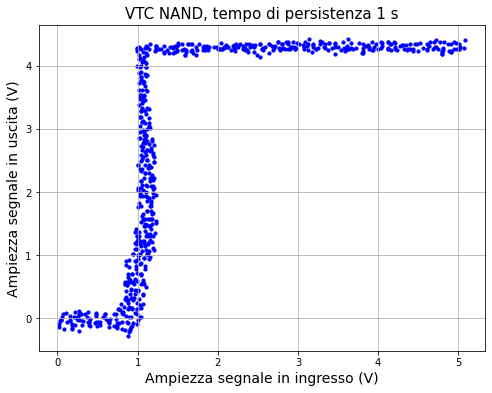

In [8]:
from numpy import loadtxt
VTC_nand = loadtxt(f'{DATADIR}/26-10-21/NAND-VTC.csv', comments="#", delimiter=",", unpack=False)
x_nand = VTC_nand.transpose()[0] + 3
y_nand = VTC_nand.transpose()[1] + 2

fig, ax  = plt.subplots(figsize=(8,6))
ax.scatter(x_nand,y_nand, s=10, color='b')

plt.xlabel('Ampiezza segnale in ingresso (V)',fontsize=14) 
plt.ylabel('Ampiezza segnale in uscita (V)',fontsize=14)
plt.title('VTC NAND, tempo di persistenza 1 s',fontsize=15)
ax.grid()
plt.savefig(f"{OUTPUTDIR}/NAND-XY.pdf")

### AND

#### AND Gate

In [101]:
CH1_and = openTek(f'{DATADIR}/26-10-21/ALL0000/F0000CH1.CSV')
CH2_and = openTek(f'{DATADIR}/26-10-21/ALL0000/F0000CH2.CSV')
CH3_and = openTek(f'{DATADIR}/26-10-21/ALL0000/F0000CH3.CSV')

time_1_and = CH1_and['Data'].to_numpy().transpose()[0]   
sig_1_and = CH1_and['Data'].to_numpy().transpose()[1]  
time_2_and = CH2_and['Data'].to_numpy().transpose()[0]   
sig_2_and = CH2_and['Data'].to_numpy().transpose()[1]
time_3_and = CH3_and['Data'].to_numpy().transpose()[0]   
sig_3_and = CH3_and['Data'].to_numpy().transpose()[1]

CH1_and2 = openTek(f'{DATADIR}/26-10-21/ALL0001/F0001CH1.CSV')
CH2_and2 = openTek(f'{DATADIR}/26-10-21/ALL0001/F0001CH2.CSV')
CH3_and2 = openTek(f'{DATADIR}/26-10-21/ALL0001/F0001CH3.CSV')

time_1_and2 = CH1_and2['Data'].to_numpy().transpose()[0]   
sig_1_and2 = CH1_and2['Data'].to_numpy().transpose()[1]  
time_2_and2 = CH2_and2['Data'].to_numpy().transpose()[0]   
sig_2_and2 = CH2_and2['Data'].to_numpy().transpose()[1]
time_3_and2 = CH3_and2['Data'].to_numpy().transpose()[0]   
sig_3_and2 = CH3_and2['Data'].to_numpy().transpose()[1]

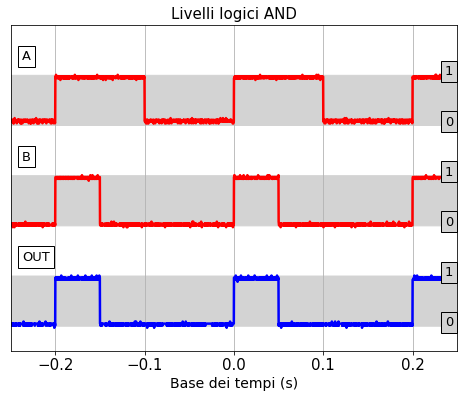

In [102]:
plotLogicLevelNoClock_3ch(sig_1_and/sig_1_and.max(), "A", sig_2_and/sig_2_and.max(), "B", sig_3_and/sig_3_and.max(), "OUT", 
                            time_1_and,time_1_and[0],time_1_and[len(time_1_and)-1],titl = 'Livelli logici AND')
plt.savefig(f"{OUTPUTDIR}/AND.pdf")

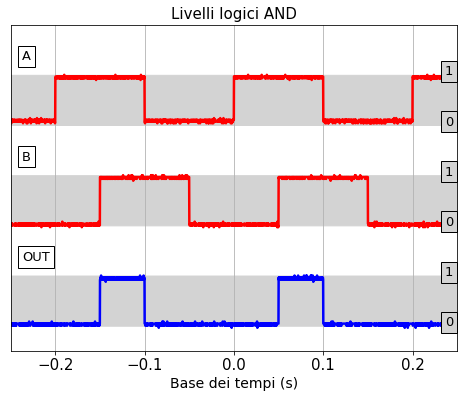

In [103]:
plotLogicLevelNoClock_3ch(sig_1_and2/sig_1_and2.max(), "A", sig_2_and2/sig_2_and2.max(), "B", sig_3_and2/sig_3_and2.max(), "OUT", 
                            time_1_and2, time_1_and2[0],time_1_and2[len(time_1_and2)-1],titl = 'Livelli logici AND')
plt.savefig(f"{OUTPUTDIR}/AND-all.pdf")

#### AND Switching

In [104]:
CH1_and3 = openTek(f'{DATADIR}/26-10-21/ALL0002/F0002CH1.CSV')
CH2_and3 = openTek(f'{DATADIR}/26-10-21/ALL0002/F0002CH2.CSV')

time_1_and3 = CH1_and3['Data'].to_numpy().transpose()[0]   
sig_1_and3 = CH1_and3['Data'].to_numpy().transpose()[1]  
time_2_and3 = CH2_and3['Data'].to_numpy().transpose()[0]   
sig_2_and3 = CH2_and3['Data'].to_numpy().transpose()[1]


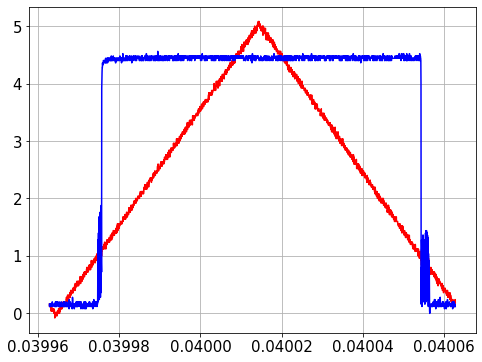

In [105]:
fig, ax  = plt.subplots(figsize=(8,6))
ax.plot(time_1_and3, sig_1_and3, color = "red", label = "Step")
ax.plot(time_2_and3, sig_2_and3, color = "blue", label = "Step")
ax.grid()


In [106]:
CH1_and4 = openTek(f'{DATADIR}/26-10-21/AND-switching2/F0003CH1.CSV')
CH2_and4 = openTek(f'{DATADIR}/26-10-21/AND-switching2/F0003CH2.CSV')

time_1_and4 = CH1_and4['Data'].to_numpy().transpose()[0]   
sig_1_and4 = CH1_and4['Data'].to_numpy().transpose()[1]  
time_2_and4 = CH2_and4['Data'].to_numpy().transpose()[0]   
sig_2_and4 = CH2_and4['Data'].to_numpy().transpose()[1]


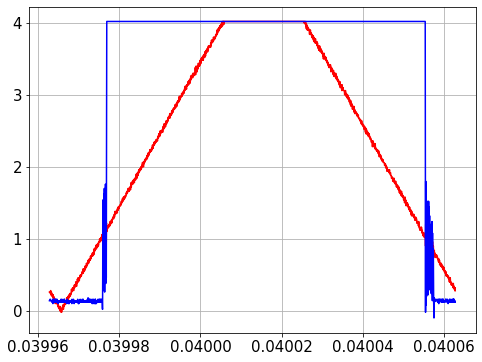

In [107]:
fig, ax  = plt.subplots(figsize=(8,6))
ax.plot(time_1_and4, sig_1_and4, color = "red", label = "Step")
ax.plot(time_2_and4, sig_2_and4, color = "blue", label = "Step")
ax.grid()


### J/K

#### J (square wave)  K (ground)

In [108]:
CH1_jk = openTek(f'{DATADIR}/26-10-21/ALL0004/F0004CH1.CSV')
CH2_jk = openTek(f'{DATADIR}/26-10-21/ALL0004/F0004CH2.CSV')
CH3_jk = openTek(f'{DATADIR}/26-10-21/ALL0004/F0004CH3.CSV')
CH4_jk = openTek(f'{DATADIR}/26-10-21/ALL0004/F0004CH4.CSV')

time_1_jk = CH1_jk['Data'].to_numpy().transpose()[0]   
sig_1_jk = CH1_jk['Data'].to_numpy().transpose()[1]  
time_2_jk = CH2_jk['Data'].to_numpy().transpose()[0]   
sig_2_jk = CH2_jk['Data'].to_numpy().transpose()[1]
time_3_jk = CH3_jk['Data'].to_numpy().transpose()[0]   
sig_3_jk = CH3_jk['Data'].to_numpy().transpose()[1]
time_4_jk = CH4_jk['Data'].to_numpy().transpose()[0]   
sig_4_jk = CH4_jk['Data'].to_numpy().transpose()[1]


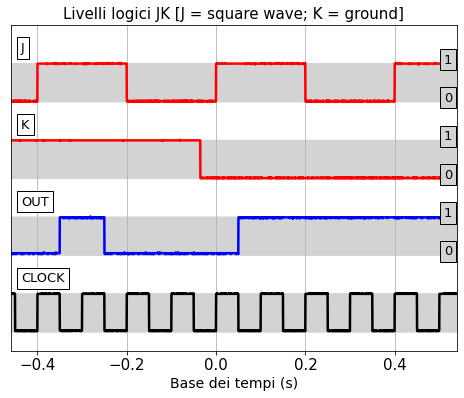

In [109]:
plotLogicLevelNoClock(sig_1_jk/sig_1_jk.max(), "J", sig_2_jk/sig_2_jk.max(), "K", sig_3_jk/sig_3_jk.max(), "OUT", sig_4_jk/sig_4_jk.max(), "CLOCK", 
                            time_1_jk, time_1_jk[0],time_1_jk[len(time_1_jk)-1],0, titl = 'Livelli logici JK [J = square wave; K = ground]')
plt.savefig(f"{OUTPUTDIR}/JK-square-ground.pdf")

#### J (ground)  K (square wave)

In [110]:
CH1_jk2 = openTek(f'{DATADIR}/26-10-21/ALL0005/F0005CH1.CSV')
CH2_jk2 = openTek(f'{DATADIR}/26-10-21/ALL0005/F0005CH2.CSV')
CH3_jk2 = openTek(f'{DATADIR}/26-10-21/ALL0005/F0005CH3.CSV')
CH4_jk2 = openTek(f'{DATADIR}/26-10-21/ALL0005/F0005CH4.CSV')

time_1_jk2 = CH1_jk2['Data'].to_numpy().transpose()[0]   
sig_1_jk2 = CH1_jk2['Data'].to_numpy().transpose()[1]  
time_2_jk2 = CH2_jk2['Data'].to_numpy().transpose()[0]   
sig_2_jk2 = CH2_jk2['Data'].to_numpy().transpose()[1]
time_3_jk2 = CH3_jk2['Data'].to_numpy().transpose()[0]   
sig_3_jk2 = CH3_jk2['Data'].to_numpy().transpose()[1]
time_4_jk2 = CH4_jk2['Data'].to_numpy().transpose()[0]   
sig_4_jk2 = CH4_jk2['Data'].to_numpy().transpose()[1]


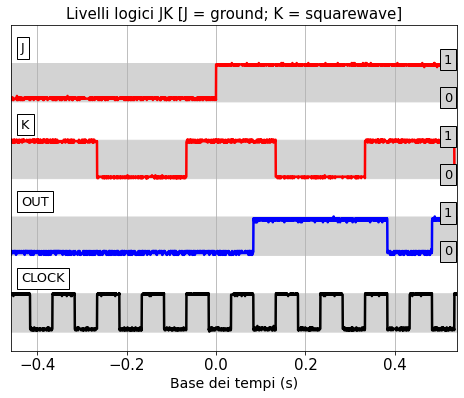

In [111]:
plotLogicLevelNoClock(sig_1_jk2/sig_1_jk2.max(), "J", sig_2_jk2/sig_2_jk2.max(), "K", sig_3_jk2/sig_3_jk2.max(), "OUT", sig_4_jk2/sig_4_jk2.max(), "CLOCK", 
                            time_1_jk2,time_1_jk2[0], time_1_jk2[len(time_1_jk2)-1],0, titl = 'Livelli logici JK [J = ground; K = squarewave]')
plt.savefig(f"{OUTPUTDIR}/JK-ground-square.pdf")

#### J K (parallel square waves)

In [112]:
CH1_jk3 = openTek(f'{DATADIR}/26-10-21/ALL0006/F0006CH1.CSV')
CH2_jk3 = openTek(f'{DATADIR}/26-10-21/ALL0006/F0006CH2.CSV')
CH3_jk3 = openTek(f'{DATADIR}/26-10-21/ALL0006/F0006CH3.CSV')
CH4_jk3 = openTek(f'{DATADIR}/26-10-21/ALL0006/F0006CH4.CSV')

time_1_jk3 = CH1_jk3['Data'].to_numpy().transpose()[0]   
sig_1_jk3 = CH1_jk3['Data'].to_numpy().transpose()[1]  
time_2_jk3 = CH2_jk3['Data'].to_numpy().transpose()[0]   
sig_2_jk3 = CH2_jk3['Data'].to_numpy().transpose()[1]
time_3_jk3 = CH3_jk3['Data'].to_numpy().transpose()[0]   
sig_3_jk3 = CH3_jk3['Data'].to_numpy().transpose()[1]
time_4_jk3 = CH4_jk3['Data'].to_numpy().transpose()[0]   
sig_4_jk3 = CH4_jk3['Data'].to_numpy().transpose()[1]


# Truth

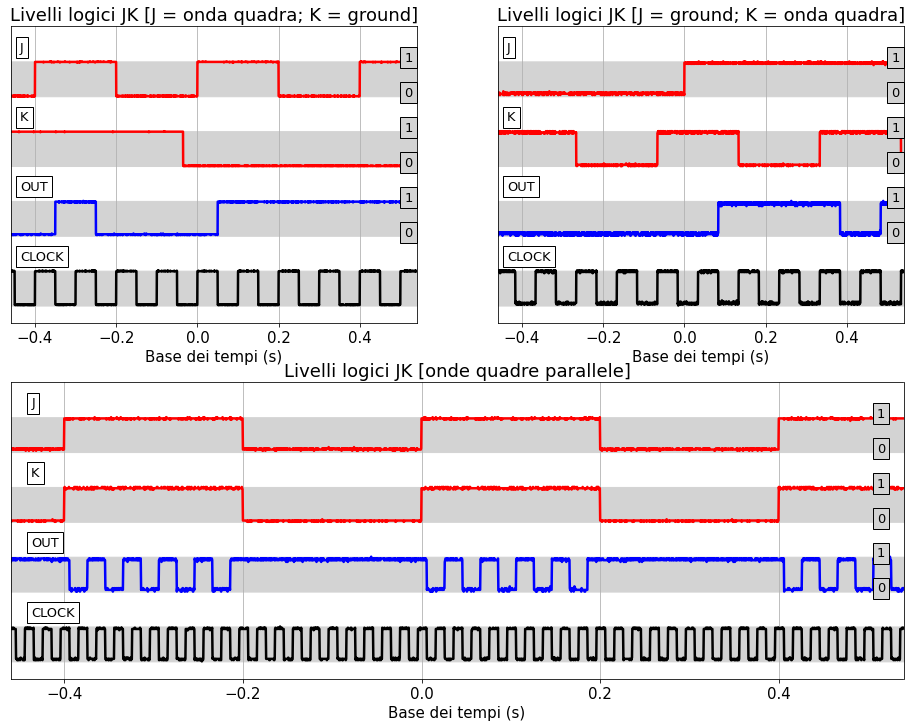

In [115]:
fig = plt.figure(figsize=(16,12))
s1 = fig.add_subplot(2,2,1)
s2 = fig.add_subplot(2,2,2)
s3 = fig.add_subplot(2,2,(3,4))

plotLogicLevelNoClockAx(s1, sig_1_jk/sig_1_jk.max(), "J", sig_2_jk/sig_2_jk.max(), "K", sig_3_jk/sig_3_jk.max(), "OUT", sig_4_jk/sig_4_jk.max(), "CLOCK", 
                            time_1_jk, time_1_jk[0],time_1_jk[len(time_1_jk)-1],0, titl = 'Livelli logici JK [J = onda quadra; K = ground]')
plotLogicLevelNoClockAx(s2,sig_1_jk2/sig_1_jk2.max(), "J", sig_2_jk2/sig_2_jk2.max(), "K", sig_3_jk2/sig_3_jk2.max(), "OUT", sig_4_jk2/sig_4_jk2.max(), "CLOCK", 
                            time_1_jk2,time_1_jk2[0], time_1_jk2[len(time_1_jk2)-1],0, titl = 'Livelli logici JK [J = ground; K = onda quadra]')
plotLogicLevelNoClockAx(s3,sig_1_jk3/sig_1_jk3.max(), "J", sig_2_jk3/sig_2_jk3.max(), "K", sig_3_jk3/sig_3_jk3.max(), "OUT", sig_4_jk3/sig_4_jk3.max(), "CLOCK", 
                            time_1_jk3,time_1_jk3[0], time_1_jk3[len(time_1_jk3)-1],0, titl = 'Livelli logici JK [onde quadre parallele]')
plt.savefig(f"{OUTPUTDIR}/JK-truth.pdf")

### DAC (Without OPAs)

#### With memory

In [18]:
CH1_D = openTek(f'{DATADIR}/26-10-21/ALL0007/F0007CH1.CSV')
CH2_D = openTek(f'{DATADIR}/26-10-21/ALL0007/F0007CH2.CSV')
CH3_D = openTek(f'{DATADIR}/26-10-21/ALL0007/F0007CH3.CSV')
CH4_D = openTek(f'{DATADIR}/26-10-21/ALL0007/F0007CH4.CSV')

time_1_D = CH1_D['Data'].to_numpy().transpose()[0]   
sig_1_D = CH1_D['Data'].to_numpy().transpose()[1]  
time_2_D = CH2_D['Data'].to_numpy().transpose()[0]   
sig_2_D = CH2_D['Data'].to_numpy().transpose()[1]
time_3_D = CH3_D['Data'].to_numpy().transpose()[0]   
sig_3_D = CH3_D['Data'].to_numpy().transpose()[1]
time_4_D = CH4_D['Data'].to_numpy().transpose()[0]   
sig_4_D = CH4_D['Data'].to_numpy().transpose()[1]


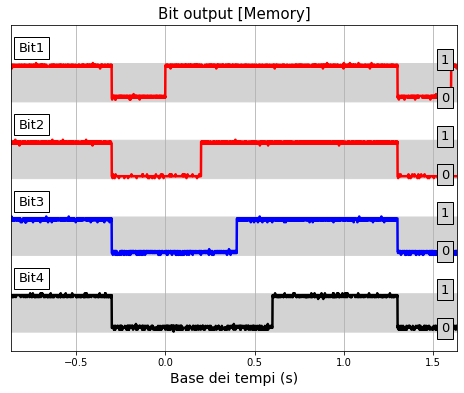

In [19]:
plotLogicLevelNoClock(sig_1_D/sig_1_D.max(), "Bit1", sig_2_D/sig_2_D.max(), "Bit2", sig_3_D/sig_3_D.max(), "Bit3", sig_4_D/sig_4_D.max(), "Bit4", 
                            time_1_D,time_1_D[0], time_1_D[len(time_1_D)-1],1, titl = 'Bit output [Memory]')
plt.savefig(f"{OUTPUTDIR}/BIT-memory.pdf")

#### With clock

In [20]:
CH1_D2 = openTek(f'{DATADIR}/26-10-21/ALL0008/F0008CH1.CSV')
CH2_D2 = openTek(f'{DATADIR}/26-10-21/ALL0008/F0008CH2.CSV')
CH3_D2 = openTek(f'{DATADIR}/26-10-21/ALL0008/F0008CH3.CSV')
CH4_D2 = openTek(f'{DATADIR}/26-10-21/ALL0008/F0008CH4.CSV')

time_1_D2 = CH1_D2['Data'].to_numpy().transpose()[0]   
sig_1_D2 = CH1_D2['Data'].to_numpy().transpose()[1]  
time_2_D2 = CH2_D2['Data'].to_numpy().transpose()[0]   
sig_2_D2 = CH2_D2['Data'].to_numpy().transpose()[1]
time_3_D2 = CH3_D2['Data'].to_numpy().transpose()[0]   
sig_3_D2 = CH3_D2['Data'].to_numpy().transpose()[1]
time_4_D2 = CH4_D2['Data'].to_numpy().transpose()[0]   
sig_4_D2 = CH4_D2['Data'].to_numpy().transpose()[1]


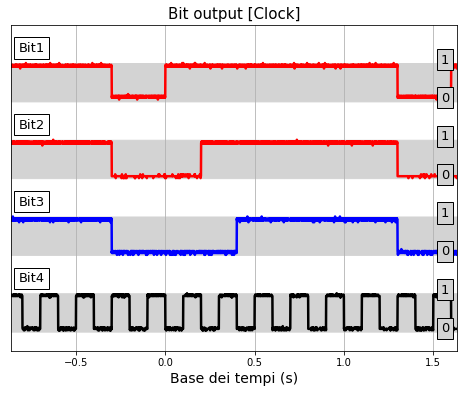

In [21]:
plotLogicLevelNoClock(sig_1_D2/sig_1_D2.max(), "Bit1", sig_2_D2/sig_2_D2.max(), "Bit2", sig_3_D2/sig_3_D2.max(), "Bit3", sig_4_D2/sig_4_D2.max(), "Bit4", 
                            time_1_D2,time_1_D2[0], time_1_D2[len(time_1_D2)-1],1, titl = 'Bit output [Clock]')
plt.savefig(f"{OUTPUTDIR}/BIT-clk.pdf")

# Cumulative Bit Memory

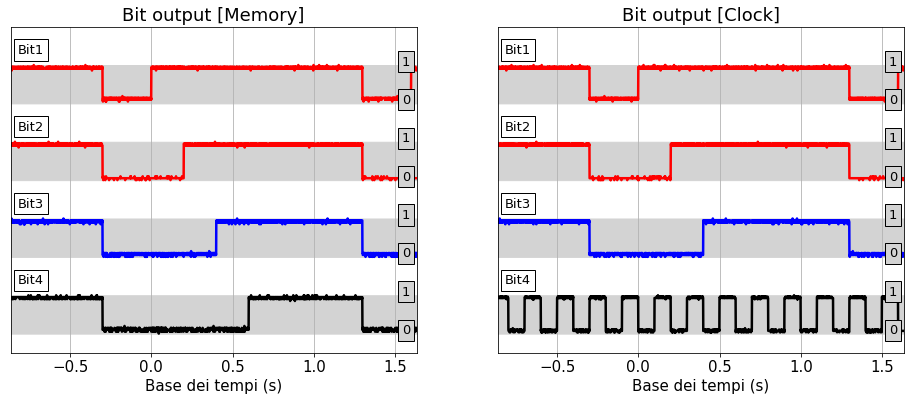

In [116]:
fig = plt.figure(figsize=(16,6))
s1 = fig.add_subplot(1,2,1)
s2 = fig.add_subplot(1,2,2)

plotLogicLevelNoClockAx(s1,sig_1_D/sig_1_D.max(), "Bit1", sig_2_D/sig_2_D.max(), "Bit2", sig_3_D/sig_3_D.max(), "Bit3", sig_4_D/sig_4_D.max(), "Bit4", 
                            time_1_D,time_1_D[0], time_1_D[len(time_1_D)-1],1, titl = 'Bit output [Memory]')

plotLogicLevelNoClockAx(s2, sig_1_D2/sig_1_D2.max(), "Bit1", sig_2_D2/sig_2_D2.max(), "Bit2", sig_3_D2/sig_3_D2.max(), "Bit3", sig_4_D2/sig_4_D2.max(), "Bit4", 
                            time_1_D2,time_1_D2[0], time_1_D2[len(time_1_D2)-1],1, titl = 'Bit output [Clock]')


plt.savefig(f"{OUTPUTDIR}/cumulative_BIT.pdf")

#### Shifting with clk

In [11]:
CH1_D3 = openTek(f'{DATADIR}/26-10-21/ALL0009/F0009CH1.CSV')
CH2_D3 = openTek(f'{DATADIR}/26-10-21/ALL0009/F0009CH2.CSV')
CH3_D3 = openTek(f'{DATADIR}/26-10-21/ALL0009/F0009CH3.CSV')
CH4_D3 = openTek(f'{DATADIR}/26-10-21/ALL0009/F0009CH4.CSV')

time_1_D3 = CH1_D3['Data'].to_numpy().transpose()[0]   
sig_1_D3 = CH1_D3['Data'].to_numpy().transpose()[1]  
time_2_D3 = CH2_D3['Data'].to_numpy().transpose()[0]   
sig_2_D3 = CH2_D3['Data'].to_numpy().transpose()[1]
time_3_D3 = CH3_D3['Data'].to_numpy().transpose()[0]   
sig_3_D3 = CH3_D3['Data'].to_numpy().transpose()[1]
time_4_D3= CH4_D3['Data'].to_numpy().transpose()[0]   
sig_4_D3 = CH4_D3['Data'].to_numpy().transpose()[1]


In [10]:
plotLogicLevelNoClock(sig_1_D3/sig_1_D3.max(), "Bit1", sig_2_D3/sig_2_D3.max(), "Bit2", sig_3_D3/sig_3_D3.max(), "Bit3", sig_4_D3/sig_4_D3.max(), "Bit4", 
                            time_1_D3,time_1_D3[0], time_1_D3[len(time_1_D3)-1],1, titl = 'Bit output [Shifting with clock]')
plt.savefig(f"{OUTPUTDIR}/BIT-shift-clk.pdf")

NameError: name 'sig_1_D3' is not defined

#### With transistor

In [24]:
CH1_D4 = openTek(f'{DATADIR}/26-10-21/ALL0010/F0010CH1.CSV')
CH2_D4 = openTek(f'{DATADIR}/26-10-21/ALL0010/F0010CH2.CSV')
CH3_D4 = openTek(f'{DATADIR}/26-10-21/ALL0010/F0010CH3.CSV')
CH4_D4 = openTek(f'{DATADIR}/26-10-21/ALL0010/F0010CH4.CSV')

time_1_D4 = CH1_D4['Data'].to_numpy().transpose()[0]   
sig_1_D4 = CH1_D4['Data'].to_numpy().transpose()[1]  
time_2_D4 = CH2_D4['Data'].to_numpy().transpose()[0]   
sig_2_D4 = CH2_D4['Data'].to_numpy().transpose()[1]
time_3_D4 = CH3_D4['Data'].to_numpy().transpose()[0]   
sig_3_D4 = CH3_D4['Data'].to_numpy().transpose()[1]
time_4_D4 = CH4_D4['Data'].to_numpy().transpose()[0]   
sig_4_D4 = CH4_D4['Data'].to_numpy().transpose()[1]


<AxesSubplot:title={'center':'Bit output [with transistor]'}, xlabel='Base dei tempi (s)'>

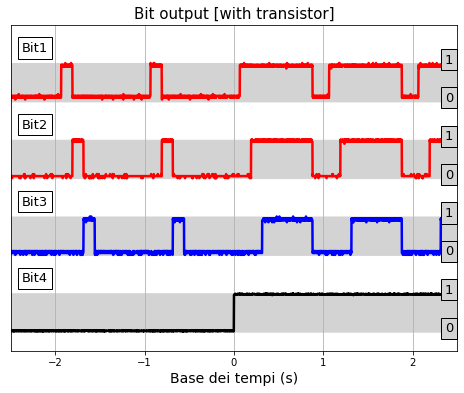

In [25]:
plotLogicLevelNoClock(sig_1_D4/sig_1_D4.max(), "Bit1", sig_2_D4/sig_2_D4.max(), "Bit2", sig_3_D4/sig_3_D4.max(), "Bit3", sig_4_D4/sig_4_D4.max(), "Bit4", 
                            time_1_D4,time_1_D4[0], time_1_D4[len(time_1_D4)-1],1, titl = 'Bit output [with transistor]')

In [26]:
CH1_D5 = openTek(f'{DATADIR}/26-10-21/ALL0011/F0011CH1.CSV')
CH2_D5 = openTek(f'{DATADIR}/26-10-21/ALL0011/F0011CH2.CSV')
CH3_D5 = openTek(f'{DATADIR}/26-10-21/ALL0011/F0011CH3.CSV')
CH4_D5 = openTek(f'{DATADIR}/26-10-21/ALL0011/F0011CH4.CSV')

time_1_D5 = CH1_D5['Data'].to_numpy().transpose()[0]   
sig_1_D5 = CH1_D5['Data'].to_numpy().transpose()[1]  
time_2_D5 = CH2_D5['Data'].to_numpy().transpose()[0]   
sig_2_D5 = CH2_D5['Data'].to_numpy().transpose()[1]
time_3_D5 = CH3_D5['Data'].to_numpy().transpose()[0]   
sig_3_D5 = CH3_D5['Data'].to_numpy().transpose()[1]
time_4_D5 = CH4_D5['Data'].to_numpy().transpose()[0]   
sig_4_D5 = CH4_D5['Data'].to_numpy().transpose()[1]


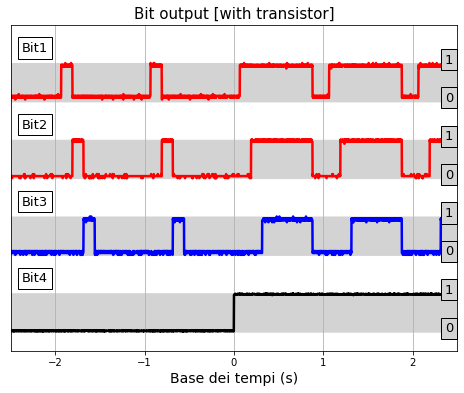

In [27]:
plotLogicLevelNoClock(sig_1_D5/sig_1_D5.max(), "Bit1", sig_2_D5/sig_2_D5.max(), "Bit2", sig_3_D5/sig_3_D5.max(), "Bit3", sig_4_D5/sig_4_D4.max(), "Bit4", 
                            time_1_D5,time_1_D5[0], time_1_D5[len(time_1_D5)-1],1, titl = 'Bit output [with transistor]')
plt.savefig(f"{OUTPUTDIR}/BIT-transistor.pdf")

# Cumulative BIT with transistor

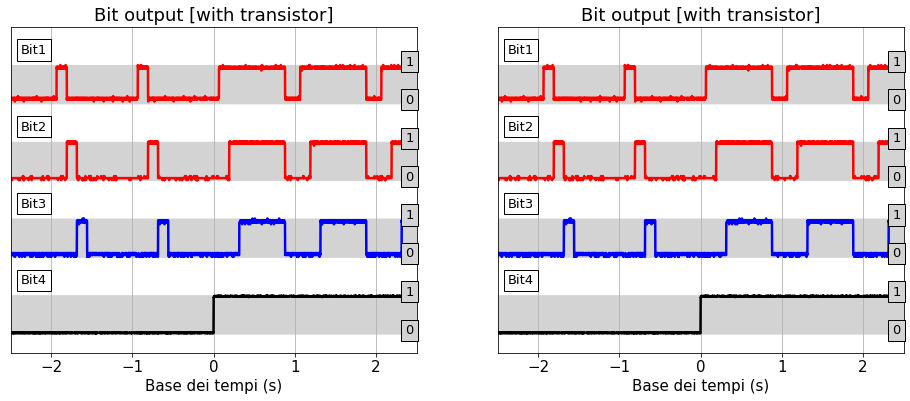

In [117]:
fig = plt.figure(figsize=(16,6))
s1 = fig.add_subplot(1,2,1)
s2 = fig.add_subplot(1,2,2)

plotLogicLevelNoClockAx(s1, sig_1_D4/sig_1_D4.max(), "Bit1", sig_2_D4/sig_2_D4.max(), "Bit2", sig_3_D4/sig_3_D4.max(), "Bit3", sig_4_D4/sig_4_D4.max(), "Bit4", 
                            time_1_D4,time_1_D4[0], time_1_D4[len(time_1_D4)-1],1, titl = 'Bit output [with transistor]')

plotLogicLevelNoClockAx(s2, sig_1_D5/sig_1_D5.max(), "Bit1", sig_2_D5/sig_2_D5.max(), "Bit2", sig_3_D5/sig_3_D5.max(), "Bit3", sig_4_D5/sig_4_D4.max(), "Bit4", 
                            time_1_D5,time_1_D5[0], time_1_D5[len(time_1_D5)-1],1, titl = 'Bit output [with transistor]')


plt.savefig(f"{OUTPUTDIR}/cumulative_BIT_with_transistor.pdf")

### BJT VTC


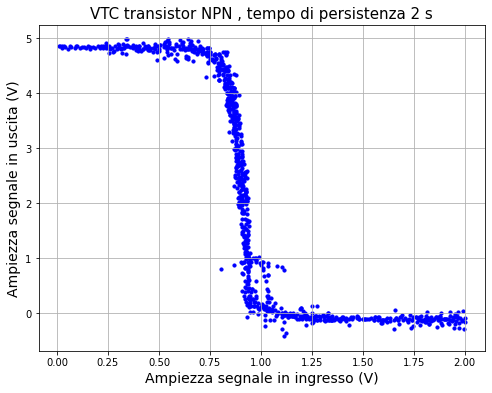

In [15]:
from numpy import loadtxt
VTC_nand = loadtxt(f'{DATADIR}/26-10-21/NPN-VTC.csv', comments="#", delimiter=",", unpack=False)
x_nand = (VTC_nand.transpose()[0] + 0.5) * 2
y_nand = VTC_nand.transpose()[1] + 2.1

fig, ax  = plt.subplots(figsize=(8,6))
ax.scatter(x_nand,y_nand, s=10, color='b')


plt.xlabel('Ampiezza segnale in ingresso (V)',fontsize=14) 
plt.ylabel('Ampiezza segnale in uscita (V)',fontsize=14)
plt.title('VTC transistor NPN , tempo di persistenza 2 s',fontsize=15)
ax.grid()
plt.savefig(f"{OUTPUTDIR}/NPN-XY.pdf")

### Test del registro

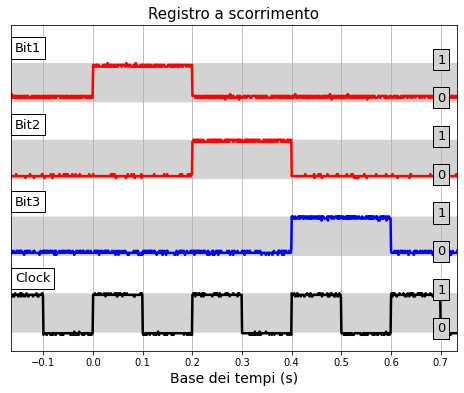

In [25]:
start   = 700
end     = 1600

sig_1_D3b = sig_1_D3[start:end]
sig_2_D3b = sig_2_D3[start:end]
sig_3_D3b = sig_3_D3[start:end]
sig_4_D3b = -1 * sig_4_D3[start:end] + 5
time_1_D3b = time_1_D3[start:end]

plotLogicLevelNoClock(sig_1_D3b/sig_1_D3b.max(), "Bit1", sig_2_D3b/sig_2_D3b.max(), "Bit2", sig_3_D3b/sig_3_D3b.max(), "Bit3", sig_4_D3b/sig_4_D3b.max(), "Clock", 
                            time_1_D3b,time_1_D3b[0], time_1_D3b[len(time_1_D3b)-1],1, titl = 'Registro a scorrimento')
plt.savefig(f"{OUTPUTDIR}/reg_test.pdf")